In [10]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

data = open("data/1_raw/2024-08-20.json")

decoder = json.decoder.JSONDecoder()
decoded_data = decoder.decode(data.read())

{'dailySleepDTO': {'id': 1724106101000,
  'userProfilePK': 125047033,
  'calendarDate': '2024-08-20',
  'sleepTimeSeconds': 29040,
  'napTimeSeconds': 0,
  'sleepWindowConfirmed': True,
  'sleepWindowConfirmationType': 'enhanced_confirmed_final',
  'sleepStartTimestampGMT': 1724106101000,
  'sleepEndTimestampGMT': 1724136461000,
  'sleepStartTimestampLocal': 1724113301000,
  'sleepEndTimestampLocal': 1724143661000,
  'autoSleepStartTimestampGMT': None,
  'autoSleepEndTimestampGMT': None,
  'sleepQualityTypePK': None,
  'sleepResultTypePK': None,
  'unmeasurableSleepSeconds': 0,
  'deepSleepSeconds': 4740,
  'lightSleepSeconds': 19020,
  'remSleepSeconds': 5280,
  'awakeSleepSeconds': 1320,
  'deviceRemCapable': True,
  'retro': False,
  'sleepFromDevice': True,
  'averageRespirationValue': 13.0,
  'lowestRespirationValue': 7.0,
  'highestRespirationValue': 16.0,
  'awakeCount': 1,
  'avgSleepStress': 6.0,
  'ageGroup': 'ADULT',
  'sleepScoreFeedback': 'POSITIVE_LONG_AND_RECOVERING',
  

### Datenfilterung

Es sind viele Daten nicht nötig. Daten aus den Frames löschen.

In [2]:
def list_all_files(path):
    try:
        files = []

        for f in os.listdir(path):
            filepath = os.path.join(path, f)
            if os.path.isfile(filepath):  # Prüft, ob es sich um eine Datei handelt
                files.append(f)

        return files
    except FileNotFoundError:
        print(f"Das Verzeichnis '{path}' wurde nicht gefunden.")
        return []

In [6]:

def extract_relevant_data(data):
    filtered_data = {}
    filtered_data["date"] = data["dailySleepDTO"]["calendarDate"]
    filtered_data["sleepStartTimestampGMT"] = data["dailySleepDTO"]["sleepStartTimestampGMT"]
    filtered_data["sleepEndTimestampGMT"] = data["dailySleepDTO"]["sleepEndTimestampGMT"]
    filtered_data["movementData"] = data["sleepMovement"]
    filtered_data["sleepLevels"] = data["sleepLevels"]
    filtered_data["sleepRestlessMoments"] = data["sleepRestlessMoments"]
    filtered_data["sleepHeartRate"] = data["sleepHeartRate"]
    filtered_data["sleepStress"] = data["sleepStress"]
    filtered_data["sleepBodyBattery"] = data["sleepBodyBattery"]
    filtered_data["hrvData"] = data["hrvData"]
    return filtered_data


encoder = json.encoder.JSONEncoder()
decoder = json.decoder.JSONDecoder()

for f in list_all_files("data/1_raw"):
    with open("data/1_raw/" + f) as readfile:
        content = readfile.read()
        data = decoder.decode(content)
        filtered_data = extract_relevant_data(data)
        with open(f"data/2_filtered/{f}", "w") as writefile:
            json = encoder.encode(filtered_data)
            writefile.write(json)
            print("Datei", f, "geschrieben!")


Datei 2024-08-23.json geschrieben!
Datei 2024-09-05.json geschrieben!
Datei 2024-09-08.json geschrieben!
Datei 2024-08-22.json geschrieben!
Datei 2024-09-19.json geschrieben!
Datei 2024-09-01.json geschrieben!
Datei 2024-08-27.json geschrieben!
Datei 2024-08-29.json geschrieben!
Datei 2024-08-21.json geschrieben!
Datei 2024-09-03.json geschrieben!
Datei 2024-09-06.json geschrieben!
Datei 2024-08-30.json geschrieben!
Datei 2024-09-02.json geschrieben!


KeyError: 'sleepHeartRate'

### Datenformatierung

Die gefilterten Daten müssen nun in für die Modelle nutzbare Formate umgeschrieben werden.

In [14]:
def get_datetime_from_str(date: str) -> datetime:
    return datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f")


def get_datetime_from_micros(micros: int) -> datetime:
    return datetime.fromtimestamp(micros / 1000)


def get_millis_from_datetime(date: datetime) -> float:
    return date.timestamp()


def normalize_data_format(data):
    startTimestamp = data["sleepStartTimestampGMT"] / 1000

    normalized_data = {
        "date": data["date"],
        "startGMT": get_datetime_from_micros(data["sleepStartTimestampGMT"]).strftime("%Y-%m-%d %H:%M:%S"),
        "endGMT": get_datetime_from_micros(data["sleepEndTimestampGMT"]).strftime("%Y-%m-%d %H:%M:%S")
    }

    for key, value in data.items():
        if isinstance(value, list) and len(value) > 1:
            normalized_data[key] = []
            for item in value:
                if isinstance(item["startGMT"], str):
                    time = get_millis_from_datetime(get_datetime_from_str(item["startGMT"]))
                else:
                    time = item["startGMT"] / 1000

                relative_time = time - startTimestamp
                n_val = item.get("activityLevel", item.get("value", -1))
                normalized_data[key].append({
                    "time": relative_time,
                    "value": n_val
                })

    return normalized_data


for f in list_all_files("data/2_filtered"):
    with open("data/2_filtered/" + f, "r") as readfile:
        content = readfile.read()
        data = decoder.decode(content)
        normalized_data = normalize_data_format(data)
        with open(f"data/3_normalized_format/{f}", "w") as writefile:
            json = encoder.encode(normalized_data)
            writefile.write(json)
            print("Datei", f, "geschrieben!")

Datei 2024-08-23.json geschrieben!
Datei 2024-09-05.json geschrieben!
Datei 2024-09-08.json geschrieben!
Datei 2024-08-22.json geschrieben!
Datei 2024-09-19.json geschrieben!
Datei 2024-09-01.json geschrieben!
Datei 2024-08-27.json geschrieben!
Datei 2024-08-29.json geschrieben!
Datei 2024-08-21.json geschrieben!
Datei 2024-09-03.json geschrieben!
Datei 2024-09-06.json geschrieben!
Datei 2024-08-30.json geschrieben!
Datei 2024-09-02.json geschrieben!


In [11]:
# Daten der verschiedenen Arrays werden in ein Array zusammengefasst
# Der Zeitindex wird auf Sekunden gesetzt
def get_squashed_arrays(data):
    
    columns = [
        "movementData",
        "sleepLevels",
        "sleepRestlessMoments",
        "sleepHeartRate",
        "sleepStress",
        "sleepBodyBattery",
        "hrvData"
    ]
    
    series_list = []
    
    for label in columns:
        series_list.append(pd.Series([x['value'] for x in data[label]], index=[x['time'] for x in data[label]]))
    
    min_time = 0
    max_time = 0
    for series in series_list:
        if series.index[0] < min_time:
            min_time = series.index[0]
        if series.index[-1] > max_time:
            max_time = series.index[-1]
    
    reindexed_list = []
    full_time_index = np.arange(min_time, max_time, 1.0)
    for series in series_list:
        reindexed_list.append(series.reindex(full_time_index).ffill())
    
    return pd.DataFrame({
        "movementData": reindexed_list[0],
        "sleepLevels": reindexed_list[1],
        "restlessMoments": reindexed_list[2],
        "heartrate": reindexed_list[3],
        "stress": reindexed_list[4],
        "bodyBattery": reindexed_list[5],
        "hrv": reindexed_list[6]
    }, index=full_time_index)


for f in list_all_files("data/3_normalized_format"):
    with open("data/3_normalized_format/" + f, "r") as readfile:
        content = readfile.read()
        data = decoder.decode(content)
        squashed_data = get_squashed_arrays(data)
        json_data = squashed_data.to_json()
        with open(f"data/4_squashed_format/{f}", "w") as writefile:
            writefile.write(json_data)
            print("Datei", f, "geschrieben!")


Datei 2024-08-23.json geschrieben!
Datei 2024-09-05.json geschrieben!
Datei 2024-09-08.json geschrieben!
Datei 2024-08-22.json geschrieben!
Datei 2024-09-19.json geschrieben!
Datei 2024-09-01.json geschrieben!
Datei 2024-08-27.json geschrieben!
Datei 2024-08-29.json geschrieben!
Datei 2024-08-21.json geschrieben!
Datei 2024-09-03.json geschrieben!
Datei 2024-09-06.json geschrieben!
Datei 2024-08-30.json geschrieben!
Datei 2024-09-02.json geschrieben!


/tmp/ipykernel_31163/1220598358.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df = pd.read_json(filename)


<Axes: >

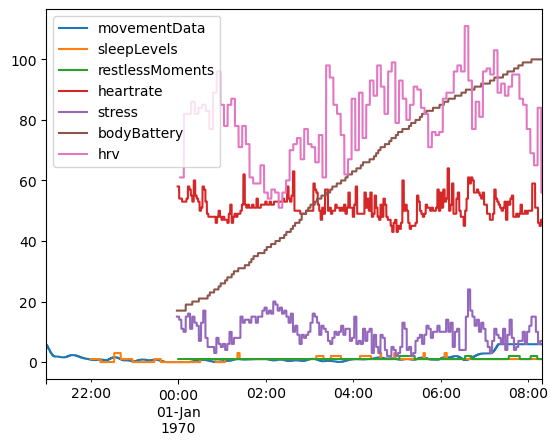